In [344]:
import numpy as np
import pandas as pd
import os
import sklearn
from sklearn import model_selection, linear_model
from sklearn.model_selection import cross_val_score, GridSearchCV
import glob
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


# Reading Data

In [7]:
def segmentWords(s): 
    return s.split()

def readFile(fileName):
    # Function for reading file
    # input: filename as string
    # output: contents of file as list containing single words
    contents = []
    f = open(fileName)
    for line in f:
        contents.append(line)
    f.close()
    result = segmentWords('\n'.join(contents))
    return result

#### Create a Dataframe containing the counts of each word in a file

In [8]:
def listdir_nohidden(path):
    return glob.glob(os.path.join(path, '*'))

In [14]:
d = []

for c in os.listdir("data_training"):
    if c != '.DS_Store':
        print(c)
        directory = "data_training/" + c
        print(directory)
    for file in os.listdir(directory):
        words = readFile(directory + "/" + file)
        e = {x:words.count(x) for x in words}
        e['__FileID__'] = file
        if directory == "data_training/neg":
            e['__CLASS__'] = 0
        else:
            e['__CLASS__'] = 1
        d.append(e)
        

neg
data_training/neg
pos
data_training/pos


Create a dataframe from d - make sure to fill all the nan values with zeros.

References:

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html


In [396]:
df  = pd.DataFrame(data=d).fillna(value=0)

#### Split data into training and validation set 

* Sample 80% of your dataframe to be the training data

* Let the remaining 20% be the validation data (you can filter out the indicies of the original dataframe that weren't selected for the training data)

References:

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html

In [397]:
# isloating y and x values - dropping filename and class for x matrix  
y_vals = df['__CLASS__']
x_vals = df.loc[:, df.columns != '__CLASS__']
x_vals = x_vals.loc[:, x_vals.columns != '__FileID__']


In [398]:
# split data set into training and validation
validation_xs, train_xs, validation_ys, train_ys  = sklearn.model_selection.train_test_split(x_vals,y_vals,test_size=0.8)

* Split the dataframe for both training and validation data into x and y dataframes - where y contains the labels and x contains the words

References:

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html

In [399]:
# verify data was correctly split (4:1 ratio in favour of training data)
len(validation_ys)*4  == len(train_ys)

True

# Logistic Regression

#### Basic Logistic Regression
* Use sklearn's linear_model.LogisticRegression() to create your model.
* Fit the data and labels with your model.
* Score your model with the same data and labels.

References:

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [408]:
# create a model based on the training data 
logistic_reg = sklearn.linear_model.LogisticRegression().fit(train_xs,train_ys)

In [409]:
# use the above model to predict the labels of the training and validation data 
predicted_ys_validation = logistic_reg.predict(validation_xs)
predicted_ys_train = logistic_reg.predict(train_xs)

In [410]:
# calculate the accuracy of the model - (percent of reviews correctly classified)
training_accuracy = float(sum(abs(train_ys  - predicted_ys_train))) / len(train_ys)
validation_accuracy = float(sum(abs(validation_ys - predicted_ys_validation))) / (len(validation_ys))

print("The training accuracy is: ", 1 - training_accuracy)
print("The validation accuracy is: ", 1 - validation_accuracy)

# equiv implementation (use in future)
training_accuracy = logistic_reg.score(train_xs,train_ys)
validation_accuracy = logistic_reg.score(validation_xs, validation_ys)


('The training accuracy is: ', 1.0)
('The validation accuracy is: ', 0.9395833333333333)


#### Changing Parameters

In [411]:
# added a regularisation term C - note that default is C=1 which gave the accuracies above
# guessed 1.5, accuracy improved on validation set. 
logistic_reg = sklearn.linear_model.LogisticRegression(C=1.5).fit(train_xs,train_ys)
predicted_ys_train = logistic_reg.predict(train_xs)
training_accuracy = logistic_reg.score(train_xs,train_ys)
print("The training accuracy is: ", training_accuracy)
validation_accuracy = logistic_reg.score(validation_xs, validation_ys)
print("The validation accuracy is: ", validation_accuracy)


('The training accuracy is: ', 1.0)
('The validation accuracy is: ', 0.93958333333333333)


In [412]:
# graph of training and validation accuracy vs regularisation const
training_accuracy = []
validation_accuracy =  []
lambdas = [0.001, 0.01, 0.1, 1, 5, 10, 100]
for param in lambdas:
    logistic_reg = sklearn.linear_model.LogisticRegression(C=param).fit(train_xs,train_ys)
    training_accuracy.append(logistic_reg.score(train_xs,train_ys))
    validation_accuracy.append(logistic_reg.score(validation_xs, validation_ys))

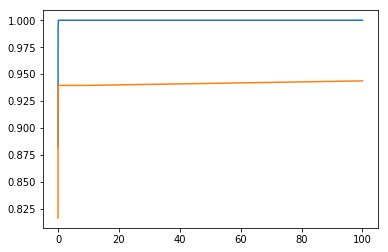

In [413]:
# plot the graphs
plt.plot(lambdas,training_accuracy)
plt.plot(lambdas,validation_accuracy)
plt.show()



#### Feature Selection
* In the backward stepsize selection method, you can remove coefficients and the corresponding x columns, where the coefficient is more than a particular amount away from the mean - you can choose how far from the mean is reasonable.

References:

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html#
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.where.html
https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.std.html
https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.mean.html

In [414]:
weights = logistic_reg.coef_[:]
# caculate z score for coefficent matrix
z_score_weights = (weights - np.mean(weights))/np.std(weights)
# use weights which are outside +- 1 sds from mean
bad_indicies = np.where((z_score_weights<1) & (z_score_weights>-1))
len(bad_indicies[1])

39959

How did you select which features to remove? Why did that reduce overfitting?

In [198]:
df = df.loc[:, df.columns != '__CLASS__']
df = df.loc[:, df.columns != '__FileID__']

In [199]:
#len(df.columns)
reduced_features = df.drop(df.columns[bad_indicies[1]], axis=1)

In [ ]:
# number of reduced features len(reduced_features.columns)
reduced_validation_xs, reduced_train_xs, validation_ys, train_ys  = sklearn.model_selection.train_test_split(reduced_features,y_vals,test_size=0.8)

In [246]:
reduced_logistic_reg = sklearn.linear_model.LogisticRegression(C=16).fit(reduced_train_xs,train_ys)

In [247]:
# calculate accuracy 
predicted_ys_train = reduced_logistic_reg.predict(reduced_train_xs)
training_accuracy = reduced_logistic_reg.score(reduced_train_xs,train_ys)
print("The training accuracy is: ", training_accuracy)
validation_accuracy = reduced_logistic_reg.score(reduced_validation_xs, validation_ys)
print("The validation accuracy is: ", validation_accuracy)

('The training accuracy is: ', 1.0)
('The validation accuracy is: ', 0.97916666666666663)


In [288]:
# use weights which are outside +- 1.5 sds from mean
bad_indicies_2 = np.where((z_score_weights<1.96) & (z_score_weights>-1.96))
print(len(bad_indicies_2[1]))
reduced_features_2 = df.drop(df.columns[bad_indicies[1]], axis=1)
reduced_validation_xs_2, reduced_train_xs_2, validation_ys, train_ys  = sklearn.model_selection.train_test_split(reduced_features_2,y_vals,test_size=0.8)

reduced_logistic_reg_2 = sklearn.linear_model.LogisticRegression().fit(reduced_train_xs_2,train_ys)
# calculate accuracy 
predicted_ys_train = reduced_logistic_reg_2.predict(reduced_train_xs_2)
training_accuracy = reduced_logistic_reg_2.score(reduced_train_xs_2,train_ys)
print("The training accuracy is: ", training_accuracy)
validation_accuracy = reduced_logistic_reg_2.score(reduced_validation_xs_2, validation_ys)
print("The validation accuracy is: ", validation_accuracy)

43529
('The training accuracy is: ', 0.9994791666666667)
('The validation accuracy is: ', 0.87916666666666665)


# Single Decision Tree

#### Basic Decision Tree

* Initialize your model as a decision tree with sklearn.
* Fit the data and labels to the model.

References:

http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html


In [429]:

clf = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 10,
                                  max_depth=12, 
                                  min_samples_leaf=5
                                 )
clf.fit(train_xs, train_ys)
predicted_test_ys = clf.predict(train_xs)
predicted_validation_ys = clf.predict(validation_xs)

In [430]:
print "Training Accuracy is ",accuracy_score(train_ys,predicted_test_ys)*100
print "Validation Accuracy is ",accuracy_score(validation_ys,predicted_validation_ys)*100

Training Accuracy is  86.9791666667
Validation Accuracy is  72.7083333333


#### Changing Parameters
* To test out which value is optimal for a particular parameter, you can either loop through various values or look into sklearn.model_selection.GridSearchCV

References:


http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [374]:
parameters = {'criterion': ("entropy","gini"), 'random_state': [0,10], 'max_depth' : [1,5,10],
               'min_samples_leaf': [1,5]}
clf = GridSearchCV(DecisionTreeClassifier(), parameters)
clf.fit(train_xs, train_ys)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'random_state': [0, 10], 'criterion': ('entropy', 'gini'), 'max_depth': [1, 5, 10], 'min_samples_leaf': [1, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

How did you choose which parameters to change and what value to give to them? Feel free to show a plot.

In [375]:
clf.best_params_

{'criterion': 'entropy',
 'max_depth': 1,
 'min_samples_leaf': 1,
 'random_state': 0}

Why is a single decision tree so prone to overfitting?

In [421]:
clf = DecisionTreeClassifier(criterion = "entropy", 
                                  random_state = 0,
                                  max_depth=10, 
                                  min_samples_leaf=1
                                 )
clf.fit(train_xs, train_ys)
print(clf.score(train_xs, train_ys))
print(clf.score(validation_xs,validation_ys))

0.879166666667
0.78125


# Random Forest Classifier

#### Basic Random Forest

* Use sklearn's ensemble.RandomForestClassifier() to create your model.
* Fit the data and labels with your model.
* Score your model with the same data and labels.

References:

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


In [370]:
clf = RandomForestClassifier()
random_forest = clf.fit(train_xs, train_ys)


In [371]:
print(random_forest.score(train_xs,train_ys))
print(random_forest.score(validation_xs,validation_ys))


0.875520833333
0.645833333333


#### Changing Parameters

In [382]:
parameters = {'criterion': ("entropy","gini"), 'random_state': [0,10], 'max_depth' : [1,5],
               'min_samples_leaf': [1,5]}
clf = GridSearchCV(RandomForestClassifier(), parameters)
clf.fit(train_xs, train_ys)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'random_state': [0, 10], 'criterion': ('entropy', 'gini'), 'max_depth': [1, 5], 'min_samples_leaf': [1, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

What parameters did you choose to change and why?

In [383]:
clf.best_params_

{'criterion': 'entropy',
 'max_depth': 1,
 'min_samples_leaf': 1,
 'random_state': 0}

How does a random forest classifier prevent overfitting better than a single decision tree?

In [437]:
clf = RandomForestClassifier(criterion='entropy',max_depth=10,min_samples_leaf=1,random_state=0)
random_forest = clf.fit(train_xs, train_ys)
print(random_forest.score(train_xs,train_ys))
print(random_forest.score(validation_xs,validation_ys))

0.755729166667
0.725
